In [1]:
import pandas as pd
import numpy as np
import os
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#### Đọc dữ liệu

In [2]:
# Đường dẫn đến thư mục chứa file
data_dir = "movielens_100k/ml-100k"

# Tải dữ liệu từ file u.data
ratings_file = os.path.join(data_dir, "u.data")
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

# Đọc dữ liệu từ file u.data
ratings = pd.read_csv(ratings_file, sep='\t', names=column_names)

#### Xây dựng ma trận đánh giá A

In [3]:
def MaTranA(X, y, shape):  
    # Lấy chỉ số hàng, cột của ma trận A
    row  = X[:,0]
    col  = X[:,1]
    # Lấy giá trị đánh giá
    data = y
    # Chuyển đổi dữ liệu thành ma trận
    matrix_sparse = sparse.csr_matrix((data,(row,col)), shape=(shape[0]+1,shape[1]+1))  
    A = matrix_sparse.todense()   
    A = A[1:,1:]  
    # Chuyển đổi ma trận thành mảng numpy               
    A = np.asarray(A)             
    return A

In [4]:
# In thông tin ma trận 
n_users = len(ratings['user_id'].unique())
n_items = len(ratings['item_id'].unique())
A_shape = (n_users, n_items)
print("Kích thước của ma trận A:", A_shape)

X = ratings[['user_id', 'item_id']].values
y = ratings['rating'].values
A = MaTranA(X, y, A_shape)
print("Ma trận đánh giá A (một phần):")
print(A)

Kích thước của ma trận A: (943, 1682)
Ma trận đánh giá A (một phần):
[[5 3 4 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]


#### Xây dựng mô hình NMF

In [5]:
def nmf_mur(A, n_components, max_iter=10000, tol=1e-6):
    # Khởi tạo U và V ngẫu nhiên
    m, n = A.shape
    U = np.random.rand(m, n_components)
    V = np.random.rand(n_components, n)

    for k in range(max_iter):   
        # Cập nhật U
        UVV = np.dot(U, np.dot(V, V.T)) # Tính toán UVV^T
        UVV[UVV == 0] = 1e-10  # Tránh chia cho 0
        U *= np.dot(A, V.T) / UVV
        
        # Cập nhật V
        UUV = np.dot(np.dot(U.T, U), V)  # Tính toán (U^T)UV
        UUV[UUV == 0] = 1e-10  # Tránh chia cho 0
        V *= np.dot(U.T, A) / UUV

        # Kiểm tra điều kiện dừng
        A_approx = np.dot(U, V)
        loss = np.linalg.norm(A - A_approx, 'fro')**2
        
        if loss < tol:
            print(f"Điều kiện dừng đạt được tại vòng lặp {k+1}.")
            break

    return U, V, A_approx

#### Đánh giá mô hình (Tính RMSE)

In [6]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
def Chia_DL(test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    A_train = MaTranA(X_train, y_train, A_shape)
    A_test = MaTranA(X_test, y_test, A_shape)
    return A_train, A_test

In [7]:
# Tính RMSE
def calculate_rmse(A, A_approx):
    A_approx = A_approx[A.nonzero()].flatten()     
    A = A[A.nonzero()].flatten() 
    return np.sqrt(mean_squared_error(A, A_approx))

#### Tìm số lượng thành phần r tối ưu

In [8]:
rmse_results = []
A_train, A_test = Chia_DL(test_size=0.33)
r_values = range(1, 101)               
for r in r_values:
    U_train, V_train, A_train_approx = nmf_mur(A_train, r)

    rmse = calculate_rmse(A_test, A_train_approx)
    rmse_results.append(rmse)
    print(f"r = {r}, RMSE = {rmse}")

r = 1, RMSE = 3.0472902981366605
r = 2, RMSE = 2.9625703081410686
r = 3, RMSE = 2.9007807327118305
r = 4, RMSE = 2.871639061107833
r = 5, RMSE = 2.850886151144245
r = 6, RMSE = 2.8332844636105263
r = 7, RMSE = 2.8174680902569205
r = 8, RMSE = 2.8054725938270093
r = 9, RMSE = 2.797140386068156
r = 10, RMSE = 2.792708729522097
r = 11, RMSE = 2.7996802129371074
r = 12, RMSE = 2.8002996846396875
r = 13, RMSE = 2.791042079672552
r = 14, RMSE = 2.7933062241123663
r = 15, RMSE = 2.784814791182827
r = 16, RMSE = 2.7889138954947854
r = 17, RMSE = 2.7955769872203655
r = 18, RMSE = 2.79396660485754
r = 19, RMSE = 2.7950258848273006
r = 20, RMSE = 2.796984457434201
r = 21, RMSE = 2.8003222240149688
r = 22, RMSE = 2.808928808934165
r = 23, RMSE = 2.8142142007206288
r = 24, RMSE = 2.8214263194100915
r = 25, RMSE = 2.821286924939643
r = 26, RMSE = 2.829731297306684
r = 27, RMSE = 2.832833456182869
r = 28, RMSE = 2.8415112547422567
r = 29, RMSE = 2.8568567029220944
r = 30, RMSE = 2.859792296531352
r =

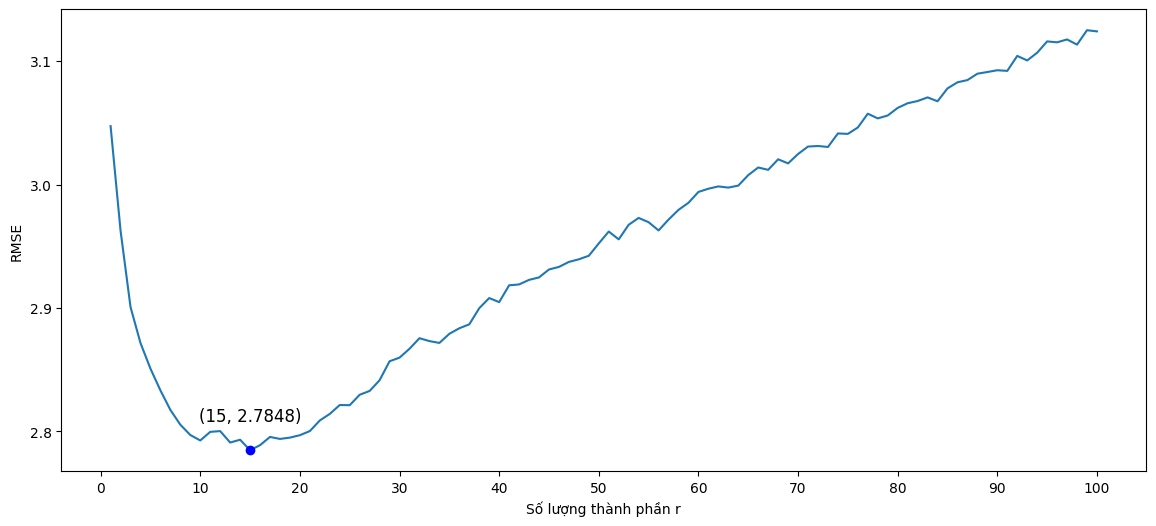

In [9]:
# Tìm giá trị tối ưu 
min_rmse = min(rmse_results)
min_index = rmse_results.index(min_rmse)
# print(f"Điểm tối ưu của bài toán tại r = {r_values[min_index]}")

# Vẽ đồ thị
plt.figure(figsize=(14, 6))
plt.plot(r_values, rmse_results)
plt.xlabel('Số lượng thành phần r')
plt.xticks(range(0, 101, 10))
plt.ylabel('RMSE')
plt.yticks([2.8, 2.9, 3.0, 3.1])

# Đánh dấu điểm tối thiểu
plt.plot(r_values[min_index], min_rmse, 'bo') 
plt.text(r_values[min_index], min_rmse + 0.02, f'({r_values[min_index]}, {min_rmse:.4f})', color='black', fontsize=12, va='bottom', ha='center')

plt.show()

#### Ứng dụng mô hình NMF

Thông tin người dùng theo user_ID

In [10]:
# Đọc dữ liệu về người dùng từ file u.user
users_file = os.path.join(data_dir, "u.user")
user_column_names = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv(users_file, sep='|', names=user_column_names)

# In ra thông tin người dùng theo user_ID
user_id = 406
print(f"\nThông tin người dùng có user_ID = {user_id}:")
user_info = users[users['user_id'] == user_id].iloc[0]
print(f"Tuổi: {user_info['age']}, Giới tính: {user_info['gender']}, Nghề nghiệp: {user_info['occupation']}, Mã bưu điện: {user_info['zip_code']}")



Thông tin người dùng có user_ID = 406:
Tuổi: 52, Giới tính: M, Nghề nghiệp: educator, Mã bưu điện: 93109


Tìm các bộ phim mà người dùng đã xem theo user_ID

In [11]:
# Đọc dữ liệu về phim từ file u.item
movies_file = os.path.join(data_dir, "u.item")
movie_column_names = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 
                      'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
                      'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(movies_file, sep='|', names=movie_column_names, encoding='latin-1')

# Lọc các bộ phim mà người dùng user_ID đã xem
user_ratings = ratings[ratings['user_id'] == user_id]

# Gộp thông tin phim và thể loại
user_movies = user_ratings.merge(movies, on='item_id')

# In ra ID phim, tên phim, thể loại và điểm đánh giá mà người dùng user_ID đã xem
print(f"\nCác bộ phim mà người dùng có user_ID = {user_id} đã đánh giá:")
print(f"STT|ID phim|Tên phim|Thể loại|Điểm đánh giá")
for index, row in user_movies.iterrows():
    # Lấy danh sách tên các thể loại phim
    genres = movies.columns[6:]  
    genre_list = ", ".join([genres[i] for i in range(len(genres)) if row.iloc[i + 6] == 1])  
    print(f"{index + 1}|{row['item_id']}|{row['title']}|{genre_list}|{row['rating']}")


Các bộ phim mà người dùng có user_ID = 406 đã đánh giá:
STT|ID phim|Tên phim|Thể loại|Điểm đánh giá
1|48|Hoop Dreams (1994)|Film-Noir|5
2|479|Vertigo (1958)|Thriller|4
3|664|Paris, Texas (1984)|Horror|2
4|823|Mulholland Falls (1996)|Fantasy, Mystery|3
5|962|Ruby in Paradise (1993)|Horror|4
6|239|Sneakers (1992)|Fantasy, Horror, Western|3
7|156|Reservoir Dogs (1992)|Fantasy|5
8|318|Schindler's List (1993)|Horror|5
9|496|It's a Wonderful Life (1946)|Horror|4
10|605|Meet Me in St. Louis (1944)|Sci-Fi|5
11|85|Ref, The (1994)|Drama|2
12|1126|Old Man and the Sea, The (1958)|Comedy, Horror|3
13|429|Day the Earth Stood Still, The (1951)|Horror, Western|4
14|488|Sunset Blvd. (1950)|Mystery|4
15|651|Glory (1989)|Children, Horror|3
16|645|Paris Is Burning (1990)|Film-Noir|5
17|14|Postino, Il (1994)|Horror, War|4
18|463|Secret of Roan Inish, The (1994)|Comedy|5
19|58|Quiz Show (1994)|Horror|4
20|469|Short Cuts (1993)|Horror|4
21|419|Mary Poppins (1964)|Documentary, Drama, Sci-Fi|1
22|436|American

Tìm thể loại phim yêu thích của người dùng theo user_ID

In [12]:
def SoThich_TheLoai(user_movies, movies):
    genre_scores = {genre: 0 for genre in movies.columns[6:]}  
    genre_counts = {genre: 0 for genre in movies.columns[6:]}

    for index, row in user_movies.iterrows():
        genres = movies.columns[6:]  
        for i in range(len(genres)):
            if row.iloc[i + 6] == 1:  
                genre_scores[genres[i]] += row['rating']  
                genre_counts[genres[i]] += 1

    return genre_scores, genre_counts

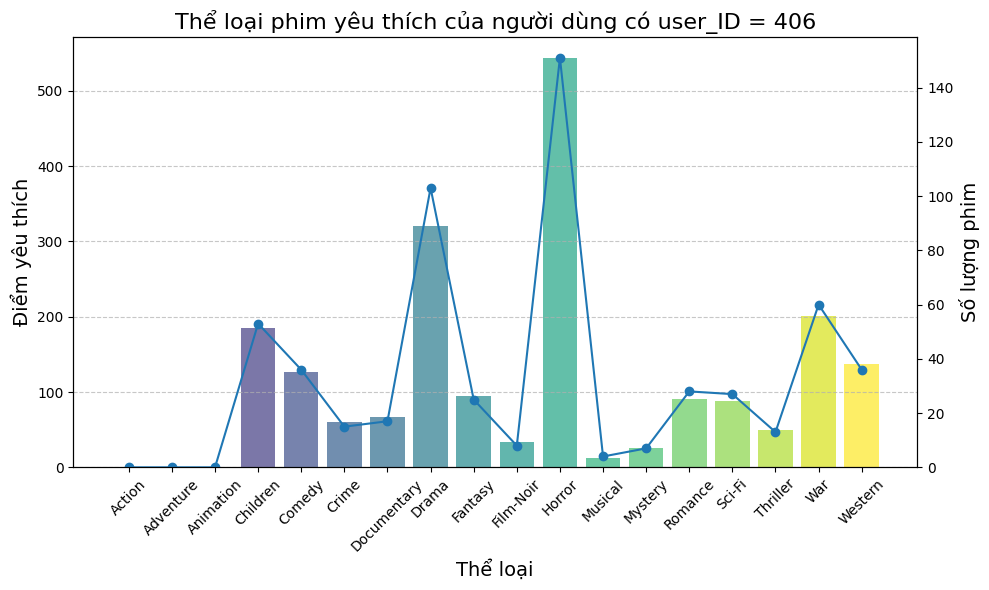

In [13]:
# Tính điểm yêu thích thể loại
genre_scores, genre_counts = SoThich_TheLoai(user_movies, movies)
# In ra sở thích thể loại
genres = list(genre_scores.keys())
scores = list(genre_scores.values())
counts = list(genre_counts.values())

# Chọn màu sắc cho các cột
colors = plt.cm.viridis(np.linspace(0, 1, len(genres)))
# Vẽ biểu đồ cột cho tổng điểm đánh giá phim của từng thể loại
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(genres, scores, color=colors, alpha=0.7)
ax1.set_xlabel("Thể loại", fontsize=14)
ax1.set_ylabel("Điểm yêu thích", fontsize=14)
plt.xticks(rotation=45)

# Vẽ biểu đồ đường cho tổng số phim đã đánh giá của từng thể loại
ax2 = ax1.twinx()
ax2.plot(genres, counts, marker='o')
ax2.set_ylabel("Số lượng phim", fontsize=14)
ax2.set_ylim(bottom=0)

# Thêm tiêu đề và lưới
plt.title(f"Thể loại phim yêu thích của người dùng có user_ID = {user_id}", fontsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị đồ thị
fig.tight_layout()
plt.show()

Gợi ý phim cho người dùng theo user_ID

In [14]:
U, V, A_approx = nmf_mur(A, 15)

# Gợi ý phim cho người dùng 
def recommend_movies(user_id, A_approx, A, n=10):
    # Lấy điểm đánh giá của người dùng từ ma trận A
    user_ratings = A[user_id - 1]
    # Tìm các phim mà người dùng chưa đánh giá
    unrated_movies = np.where(user_ratings == 0)[0] 
    # Lấy điểm dự đoán cho các phim chưa đánh giá từ ma trận A_approx
    predicted_scores = A_approx[user_id - 1, unrated_movies]  
    # Giới hạn điểm dự đoán 
    predicted_scores = np.clip(predicted_scores, 1, 5) 
    # Sắp xếp điểm dự đoán theo thứ tự giảm dần và chọn ra 10 phim có điểm cao nhất
    recommended_indices = np.argsort(predicted_scores)[::-1][:n]  
    return unrated_movies[recommended_indices], predicted_scores[recommended_indices]

In [15]:
recommended_movies, predicted_scores = recommend_movies(user_id, A_approx, A)

print(f"\nPhim gợi ý cho người dùng có user_ID = {user_id}:")
print(f"ID phim|Tên phim|Thể loại|Điểm dự đoán")
for movie_index, score in zip(recommended_movies, predicted_scores):
    movie_info = movies[movies['item_id'] == movie_index + 1]  
    # Lấy tên của bộ phim
    title = movie_info['title'].values[0]
    # Lấy danh sách tên các thể loại phim
    genres = movie_info.columns[6:]  
    genre_list = [genre for genre in genres if movie_info[genre].values[0] == 1]
    print(f"{movie_index + 1}|{title}|{', '.join(genre_list)}|{score:.2f}")


Phim gợi ý cho người dùng có user_ID = 406:
ID phim|Tên phim|Thể loại|Điểm dự đoán
603|Rear Window (1954)|Mystery, Thriller|5.00
200|Shining, The (1980)|Horror|4.08
484|Maltese Falcon, The (1941)|Film-Noir, Mystery|4.07
423|E.T. the Extra-Terrestrial (1982)|Children, Drama, Fantasy, Sci-Fi|3.88
192|Raging Bull (1980)|Drama|3.12
83|Much Ado About Nothing (1993)|Comedy, Romance|3.11
178|12 Angry Men (1957)|Drama|3.09
659|Arsenic and Old Lace (1944)|Comedy, Mystery, Thriller|2.92
475|Trainspotting (1996)|Drama|2.90
288|Scream (1996)|Horror, Thriller|2.75


#### So sánh NMF với SVD

Xây dựng mô hình SVD

In [16]:
def svd(A, n_components):
    model_svd = TruncatedSVD(n_components, random_state=42)
    model_svd.fit(A)                     
    A_approx = model_svd.inverse_transform(model_svd.transform(A))
    return A_approx

Tính RMSE

Train = 90%
r = 20, NMF - RMSE: 2.4870762330149625, SVD - RMSE: 2.4982409956213227
r = 40, NMF - RMSE: 2.553044657889071, SVD - RMSE: 2.644148277599094
r = 60, NMF - RMSE: 2.6802885546350903, SVD - RMSE: 2.802631698480677
r = 80, NMF - RMSE: 2.7524460403341084, SVD - RMSE: 2.9444443303368186
r = 100, NMF - RMSE: 2.83827334064829, SVD - RMSE: 3.0568136994870123
Train = 80%
r = 20, NMF - RMSE: 2.621121501245039, SVD - RMSE: 2.6404161599947993
r = 40, NMF - RMSE: 2.6999606787885644, SVD - RMSE: 2.80135464240466
r = 60, NMF - RMSE: 2.806260389992381, SVD - RMSE: 2.9484041757747335
r = 80, NMF - RMSE: 2.8828435889520176, SVD - RMSE: 3.071198579603502
r = 100, NMF - RMSE: 2.9616445537505585, SVD - RMSE: 3.1689657680435497
Train = 70%
r = 20, NMF - RMSE: 2.766973169259909, SVD - RMSE: 2.797719676092625
r = 40, NMF - RMSE: 2.868040960316299, SVD - RMSE: 2.952113184530838
r = 60, NMF - RMSE: 2.952613043803529, SVD - RMSE: 3.0828201939370117
r = 80, NMF - RMSE: 3.03303325735866, SVD - RMSE: 3.18

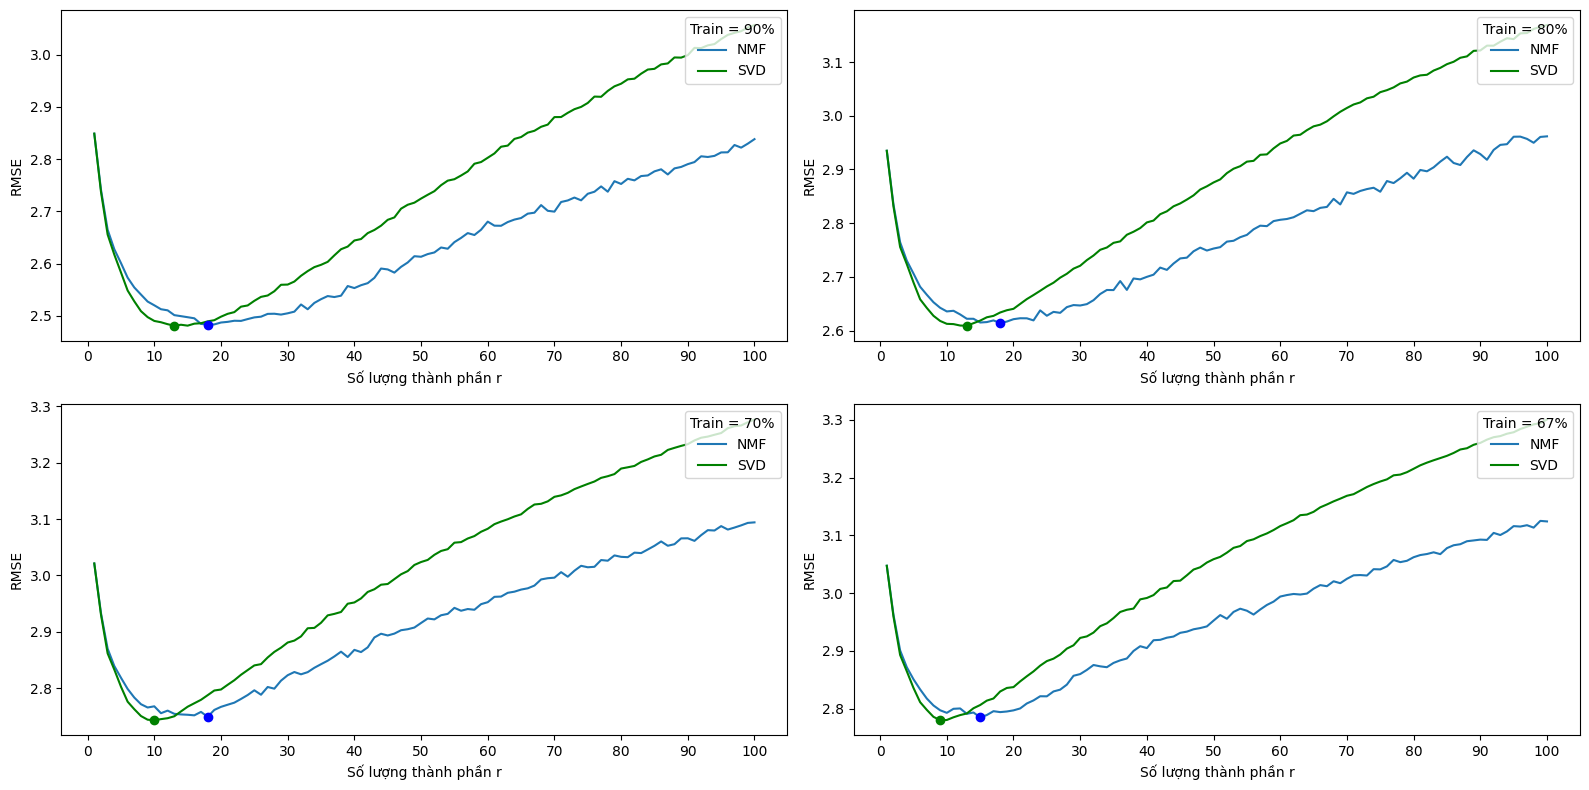

In [ ]:
index = 0
plt.figure(figsize=(16, 8))
for test_size in [0.1, 0.2, 0.3, 0.33]:
    nmf_rmse_results = []
    svd_rmse_results = []
    A_train, A_test = Chia_DL(test_size)
    r_values = range(1, 101)
    print(f"Train = {(1 - test_size)*100:.0f}%")
    for r in r_values: 
        # NMF
        U_nmf, V_nmf, A_approx_nmf = nmf_mur(A_train, r)
        nmf_rmse = calculate_rmse(A_test, A_approx_nmf)
        nmf_rmse_results.append(nmf_rmse)

        # SVD
        A_approx_svd = svd(A_train, r)
        svd_rmse = calculate_rmse(A_test, A_approx_svd)
        svd_rmse_results.append(svd_rmse)

        # In kết quả
        if (r % 20 == 0):
            print(f"r = {r}, NMF - RMSE: {nmf_rmse}, SVD - RMSE: {svd_rmse}")

    # Tìm giá trị tối ưu 
    min_nmf_rmse = min(nmf_rmse_results)
    min_nmf_index = nmf_rmse_results.index(min_nmf_rmse)

    min_svd_rmse = min(svd_rmse_results)
    min_svd_index = svd_rmse_results.index(min_svd_rmse)

    # Vẽ đồ thị
    index += 1
    plt.subplot(2, 2, index)
    plt.plot(r_values, nmf_rmse_results, label='NMF')
    plt.plot(r_values, svd_rmse_results, label='SVD', color='green')
    plt.xlabel('Số lượng thành phần r')
    plt.xticks(range(0, 101, 10))
    plt.ylabel('RMSE')  
    plt.legend(title=f'Train = {(1 - test_size)*100:.0f}%', loc='upper right')

    # Đánh dấu điểm tối thiểu
    plt.plot(r_values[min_nmf_index], min_nmf_rmse, 'bo') 
    plt.plot(r_values[min_svd_index], min_svd_rmse, 'go')

plt.tight_layout()
plt.show()